In [38]:
'''

The purpose/objective of this notebook is :


The following notebooks should be run before this notebook or are used to generate input files for the notebook:




# save all the global variable in a dataclass G
@dataclass
class G():
    Class to hold global variables
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files

    #output files

    #variables to change
    save_output=True
    save_output_figures=False


'''

"\n\nThe purpose/objective of this notebook is :\n\n\nThe following notebooks should be run before this notebook or are used to generate input files for the notebook:\n\n\n\n\n# save all the global variable in a dataclass G\n@dataclass\nclass G():\n    Class to hold global variables\n    write_dir='/home/ubuntu/write/'\n    repo_parent_dir='../../'\n    WRITE_CACHE=False\n    #input files\n\n    #output files\n\n    #variables to change\n    save_output=True\n    save_output_figures=False\n\n\n"

In [39]:
%%bash
cd
pwd
cd /home/ubuntu/data/ARCHS4/
ls

/home/ubuntu
archs4_gene_human_v2.1.2.h5


## Global variables

In [40]:
# save all the global variable in a dataclass G
from dataclasses import dataclass
@dataclass
class G():
    '''Class to hold global variables'''
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files
    ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/archs4_gene_human_v2.1.2.h5'

    #output files

    #variables to change
    save_output=True
    save_output_figures=False

    

# libraries standard paths and settings

In [41]:
#write_dir='/home/ubuntu/write/'
#repo_parent_dir='../../'

import sys
if G.repo_parent_dir not in sys.path:
    sys.path.append(G.repo_parent_dir)

import adata_and_scanpy_tools as asctl

import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#WRITE_CACHE=False # use false if  in github repo or cache files not in git ignore

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [42]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [43]:
### import extra packages
import h5py
import scipy as sp
import h5sparse

# Analysis starts here:

### filter  and other functions

In [44]:
def load_ARCHS4_H5_to_df( ARCHS4_H5_file):
    '''load a ARCHS4_H5 file to a pandas dataframe'''
    ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    meta_samples = ARCHS4_H5['meta/samples']
    df = pd.DataFrame()
    for name, item in meta_samples.items():
        if isinstance(item, h5py.Dataset):
            values = item[:]
            values = [val.decode('utf-8') if isinstance(val, bytes) else val for val in values]
            df[name]= values
            df[name]= df[name].astype(item.dtype) 
    # now re order the columns
    new_column_order=['geo_accession', 'title', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'library_selection', 'library_source', 'library_strategy', 'platform_id', 'instrument_model', 'relation', 'series_id', 'sra_id', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'data_processing', 'singlecellprobability']
    df = df[new_column_order].copy()
    return df


def basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=.5):
    df=df.loc[(df['library_selection'].isin(['cDNA']))
              &(df['molecule_ch1'].isin(['total RNA','polyA RNA']))
              &(df['singlecellprobability']<min_singlecellprobability)
              ,:].copy()
    print('filtering for library_selection = cDNA')
    print('filtering for molecule_ch1 =total RNA or polyA RNA')
    print(f'filtering for singlecellprobability <{min_singlecellprobability}')
    return df

def filter_df(df, search_strings, include=True,ignore_columns=None):
    # now filter rows of df to only include rows where an arbitrary list of string is present
    bolean_table= df.applymap(lambda x: x if pd.isnull(x) else any(search_string in x for search_string in search_strings) if isinstance(x, str) else False)
    # now remove the columns that are in ignore_columns from the bolean_table 'result' df
    if ignore_columns:
       bolean_table=bolean_table.drop(columns=ignore_columns)
    if include:
        df=df.loc[bolean_table.any(axis=1),:].copy()
        print(f'filtering to include {search_strings}')
    else:
        df=df.loc[~bolean_table.any(axis=1),:].copy()
        print(f'filtering to exclude {search_strings}')
    return df

## load then process and save processed data

### load data

In [45]:
%%time
#from G.ARCHS4_H5_file
print(G.ARCHS4_H5_file) 
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
print("Groups in HDF5 file:")
for group in list(ARCHS4_H5.keys()):
    print(group)

/home/ubuntu/data/ARCHS4/archs4_gene_human_v2.1.2.h5
Groups in HDF5 file:
data
meta
CPU times: user 993 µs, sys: 214 µs, total: 1.21 ms
Wall time: 1.7 ms


### load the metadata

In [46]:

df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
print(df_meta_src.shape)
#df_meta_src.to_csv('meta_samples.csv', index=False)
#df_meta_src=pd.read_csv('meta_samples.csv')
df_meta_src.head(2)

(620825, 29)


,geo_accession,title,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,characteristics_ch1,molecule_ch1,extract_protocol_ch1,library_selection,library_source,library_strategy,platform_id,instrument_model,relation,series_id,sra_id,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute,data_processing,singlecellprobability
0,GSM1000981,OCI-LY1_48hrs_mRNAseq_3x_siNT_R1,Public on Aug 05 2013,Sep 10 2012,May 15 2019,SRA,1,Human DLBCL cel line,Homo sapiens,9606,"treatment: siNT,cell line: OCI-LY1",total RNA,ChIP-seq libraries were prepared using the Ill...,cDNA,transcriptomic,RNA-Seq,GPL15433,Illumina HiSeq 1000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,GSE29282,"SRR566986,SRR566987,SRR566988,SRR566989,SRR566...","Katerina,,Hatzi","413 E 69th Street, BB-1462",New York,,USA,WCMC,ChIP-seq: Raw images generated went through pr...,0.043917
1,GSM1000982,OCI-LY1_48hrs_mRNAseq_3x_siNT_R2,Public on Aug 05 2013,Sep 10 2012,May 15 2019,SRA,1,Human DLBCL cel line,Homo sapiens,9606,"treatment: siNT,cell line: OCI-LY1",total RNA,ChIP-seq libraries were prepared using the Ill...,cDNA,transcriptomic,RNA-Seq,GPL15433,Illumina HiSeq 1000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,GSE29282,"SRR567014,SRR567015,SRR567016,SRR567017,SRR567...","Katerina,,Hatzi","413 E 69th Street, BB-1462",New York,,USA,WCMC,ChIP-seq: Raw images generated went through pr...,0.032111


In [47]:
df=df_meta_src.copy()
#df.dtypes

#### check out the compositin of columns

Homo sapiens    620825
Name: organism_ch1, dtype: int64
RNA-Seq    620825
Name: library_strategy, dtype: int64
cDNA                  617866
CAGE                    1845
size fractionation       874
RACE                     204
RANDOM                    20
other                     16
Name: library_selection, dtype: int64
total RNA          453116
polyA RNA          166715
genomic DNA           417
nuclear RNA           328
cytoplasmic RNA       200
protein                33
other                  16
Name: molecule_ch1, dtype: int64


<AxesSubplot: >

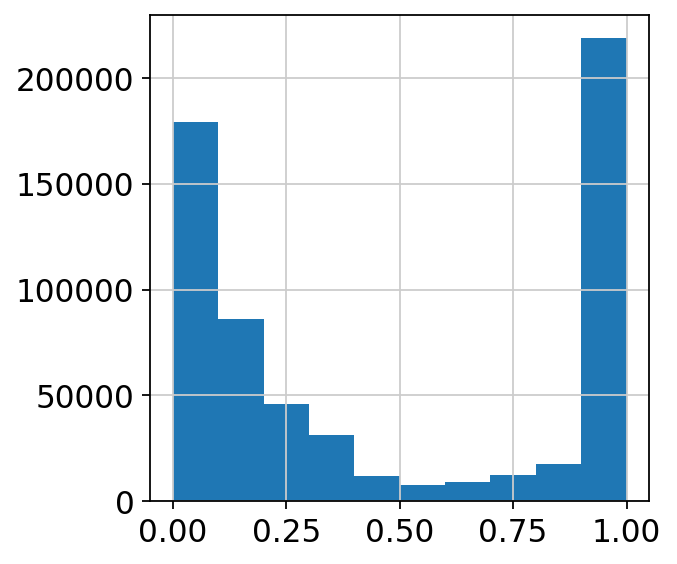

In [48]:
print(df['organism_ch1'].value_counts())
print(df['library_strategy'].value_counts())
print(df['library_selection'].value_counts())
print(df['molecule_ch1'].value_counts()) # RNA
#print(df['type'].value_counts())
#print(df['status'].value_counts())
#print(df['platform_id'].value_counts())
#print(df['instrument_model'].value_counts())
#print(df['relation'].value_counts())
#print(df['series_id'].value_counts())
#print(df['sra_id'].value_counts())
#print(df['data_processing'].value_counts())
df['singlecellprobability'].hist()

### filter  the data

#### now do a basic filter for RNA gene expression and some cut off for single cell probability

(620825, 29)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.2
(263902, 29)


<AxesSubplot: >

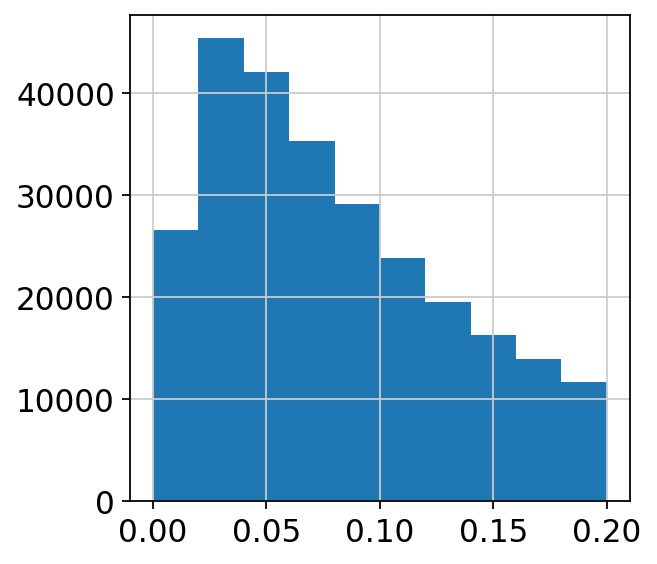

In [49]:
df=df_meta_src.copy()
print(df.shape)
df=basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=.2)
print(df.shape)
#df.to_csv('meta_samples_small.csv', index=False)
df['singlecellprobability'].hist()

In [50]:
df.tail(3)   


,geo_accession,title,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,characteristics_ch1,molecule_ch1,extract_protocol_ch1,library_selection,library_source,library_strategy,platform_id,instrument_model,relation,series_id,sra_id,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute,data_processing,singlecellprobability
620801,GSM999568,Control Und. 10,Public on Oct 04 2012,Sep 08 2012,May 15 2019,SRA,1,Brain cortex,Homo sapiens,9606,"tissue: Human brain cortex (BA9),disease state...",polyA RNA,RNA was extracted from frozen brain tissue usi...,cDNA,transcriptomic,RNA-Seq,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,GSE40710,SRR563534,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University,Illumina reads were converted to FASTQ Sanger ...,0.161417
620808,GSM999575,Parkinson's Disease PD 1,Public on Oct 04 2012,Sep 08 2012,May 15 2019,SRA,1,Brain cortex,Homo sapiens,9606,"tissue: Human brain cortex (BA9),disease state...",polyA RNA,RNA was extracted from frozen brain tissue usi...,cDNA,transcriptomic,RNA-Seq,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,GSE40710,SRR563541,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University,Illumina reads were converted to FASTQ Sanger ...,0.190284
620821,GSM999588,Parkinson's Disease PD 14,Public on Oct 04 2012,Sep 08 2012,May 15 2019,SRA,1,Brain cortex,Homo sapiens,9606,"tissue: Human brain cortex (BA9),disease state...",polyA RNA,RNA was extracted from frozen brain tissue usi...,cDNA,transcriptomic,RNA-Seq,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,GSE40710,SRR563554,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University,Illumina reads were converted to FASTQ Sanger ...,0.161673


#### now all do a new filter

In [68]:


#### now all do a new filter
df=df_meta_src.copy()
min_singlecellprobability=.2
print(df.shape)
df=basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=min_singlecellprobability)
print(df.shape)
# list of Strings to check for to include
search_strings=['microglia', 'macrophage']
df=filter_df(df, search_strings,#ignore_columns=['title', 'characteristics_ch1','extract_protocol_ch1','source_name_ch1','data_processing']
             )
print(df.shape)
# list of Strings to check for to exclude
search_strings=['iPSC', 'monocyte']
df=filter_df(df, search_strings, include=False,#ignore_columns=['title', 'characteristics_ch1','extract_protocol_ch1','source_name_ch1','data_processing']
             )
print(df.shape)
df.to_csv('meta_samples_small.csv', index=False)
df.tail(3)


(620825, 29)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.2
(263902, 29)
filtering to include ['microglia', 'macrophage']
(5877, 29)
filtering to exclude ['iPSC', 'monocyte']
(3502, 29)


,geo_accession,title,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,characteristics_ch1,molecule_ch1,extract_protocol_ch1,library_selection,library_source,library_strategy,platform_id,instrument_model,relation,series_id,sra_id,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute,data_processing,singlecellprobability
618354,GSM6544227,02 Huh6+Mac,Public on Sep 09 2022,Sep 06 2022,Sep 09 2022,SRA,1,Liver,Homo sapiens,9606,"tissue: Liver,cell line: Huh6,cell type: cance...",total RNA,RNA was harvested using Rneasy mini plus kit (...,cDNA,transcriptomic,RNA-Seq,GPL18573,Illumina NextSeq 500,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,GSE212734,SRR21430637,"Yoshihiro,,Komohara","Honjo 1â1â1, Chuouku",Kumamoto,,Japan,"Graduate School of Medical Sciences, Kumamoto ...","illumina Local Run Manager v2.4.0,Sequence rea...",0.108401
618356,GSM6544229,04 HepG2+Mac,Public on Sep 09 2022,Sep 06 2022,Sep 09 2022,SRA,1,Liver,Homo sapiens,9606,"tissue: Liver,cell line: HepG2,cell type: canc...",total RNA,RNA was harvested using Rneasy mini plus kit (...,cDNA,transcriptomic,RNA-Seq,GPL18573,Illumina NextSeq 500,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,GSE212734,SRR21430635,"Yoshihiro,,Komohara","Honjo 1â1â1, Chuouku",Kumamoto,,Japan,"Graduate School of Medical Sciences, Kumamoto ...","illumina Local Run Manager v2.4.0,Sequence rea...",0.074854
618358,GSM6544231,06 H23_Mac CM,Public on Sep 09 2022,Sep 06 2022,Sep 09 2022,SRA,1,Lung,Homo sapiens,9606,"tissue: Lung,cell line: NCI-H23,cell type: can...",total RNA,RNA was harvested using Rneasy mini plus kit (...,cDNA,transcriptomic,RNA-Seq,GPL18573,Illumina NextSeq 500,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,GSE212734,SRR21430633,"Yoshihiro,,Komohara","Honjo 1â1â1, Chuouku",Kumamoto,,Japan,"Graduate School of Medical Sciences, Kumamoto ...","illumina Local Run Manager v2.4.0,Sequence rea...",0.095207


### save processed data

In [53]:
#data_gex = ARCHS4_H5['data/expression'][:]
#print(data_gex.shape)
#print(data_gex)

### further anlaysis of the data 

# Analysis ends here